# **Architecture**

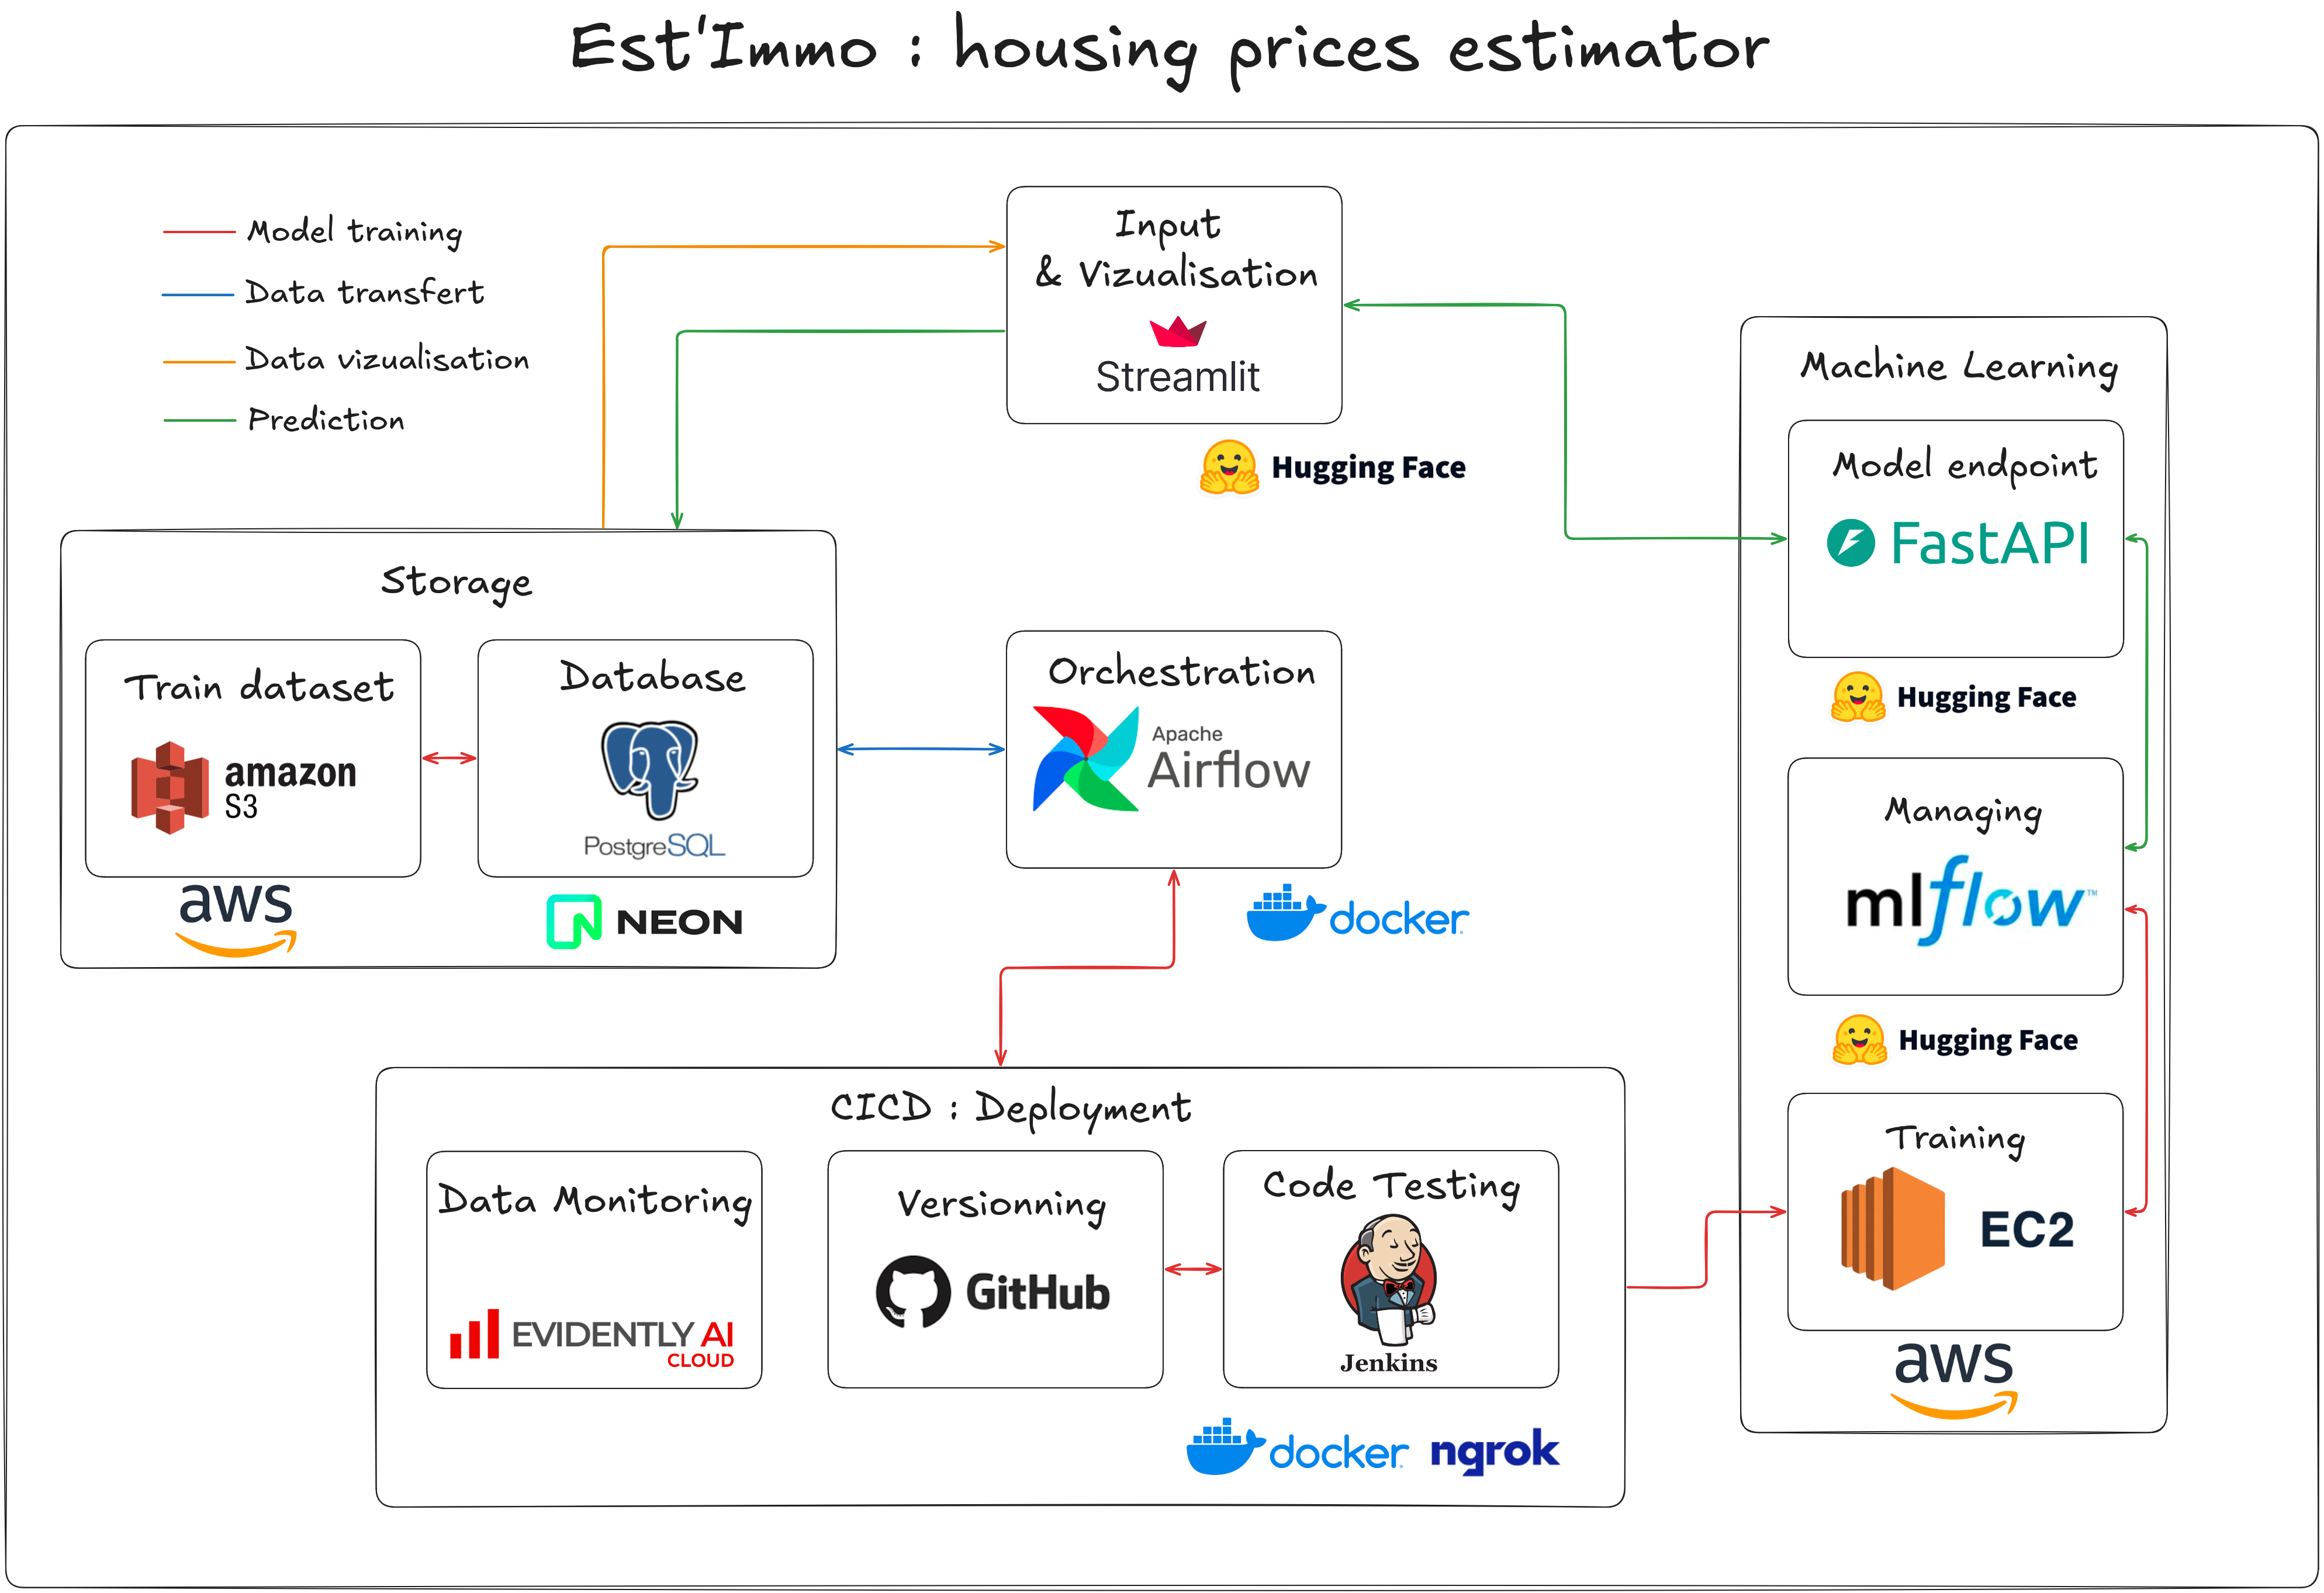

This application integrates several tools and services to handle orchestration, model management, storage, API exposure, user interface, and CI/CD.

### Orchestration, Model Management & Infrastructure

- **Airflow** manages and orchestrates the application workflows, from data ingestion to model deployment.
- **MLflow** is used for model tracking, storage, versioning, and serving models for predictions.
- **Amazon EC2** is used as a remote compute environment for training machine learning models, providing the necessary resources for heavy computation.

### Storage

- **Amazon S3** stores raw data and intermediate artifacts, offering scalable and durable object storage.
- **PostgreSQL** is the primary relational database with two schemas:
  - `housing_prices`: The real estate estimator database.
  - `mlflow`: used by MLflow to store experiments, runs, parameters, metrics, and model artifacts.

### API & User Interface

- **FastAPI** provides a RESTful API to expose the model and application logic.
- **Streamlit** delivers a user-friendly web interface to visualize database content and model results

### CI/CD and Testing

- **GitHub** is used for source code management, version control, and team collaboration.
- **Jenkins** automates CI/CD workflows including testing, building, and deployment of the application.
- **Evidently** detecting data drift and generating alerts on anomalies.

**Note**: Free services are prioritized for deployment:

- **Hugging Face Spaces**: Hosts MLflow, FastAPI, and Streamlit.
- **NeonDB**: Serves as the managed PostgreSQL database.
- **Docker**: Used for running local instances of Airflow and Jenkins.
- **Ngrok**: Creates secure tunnels to expose local services online.

# **Workflows**

There are two kinds of workflows used in this app:


## Outside Airflow

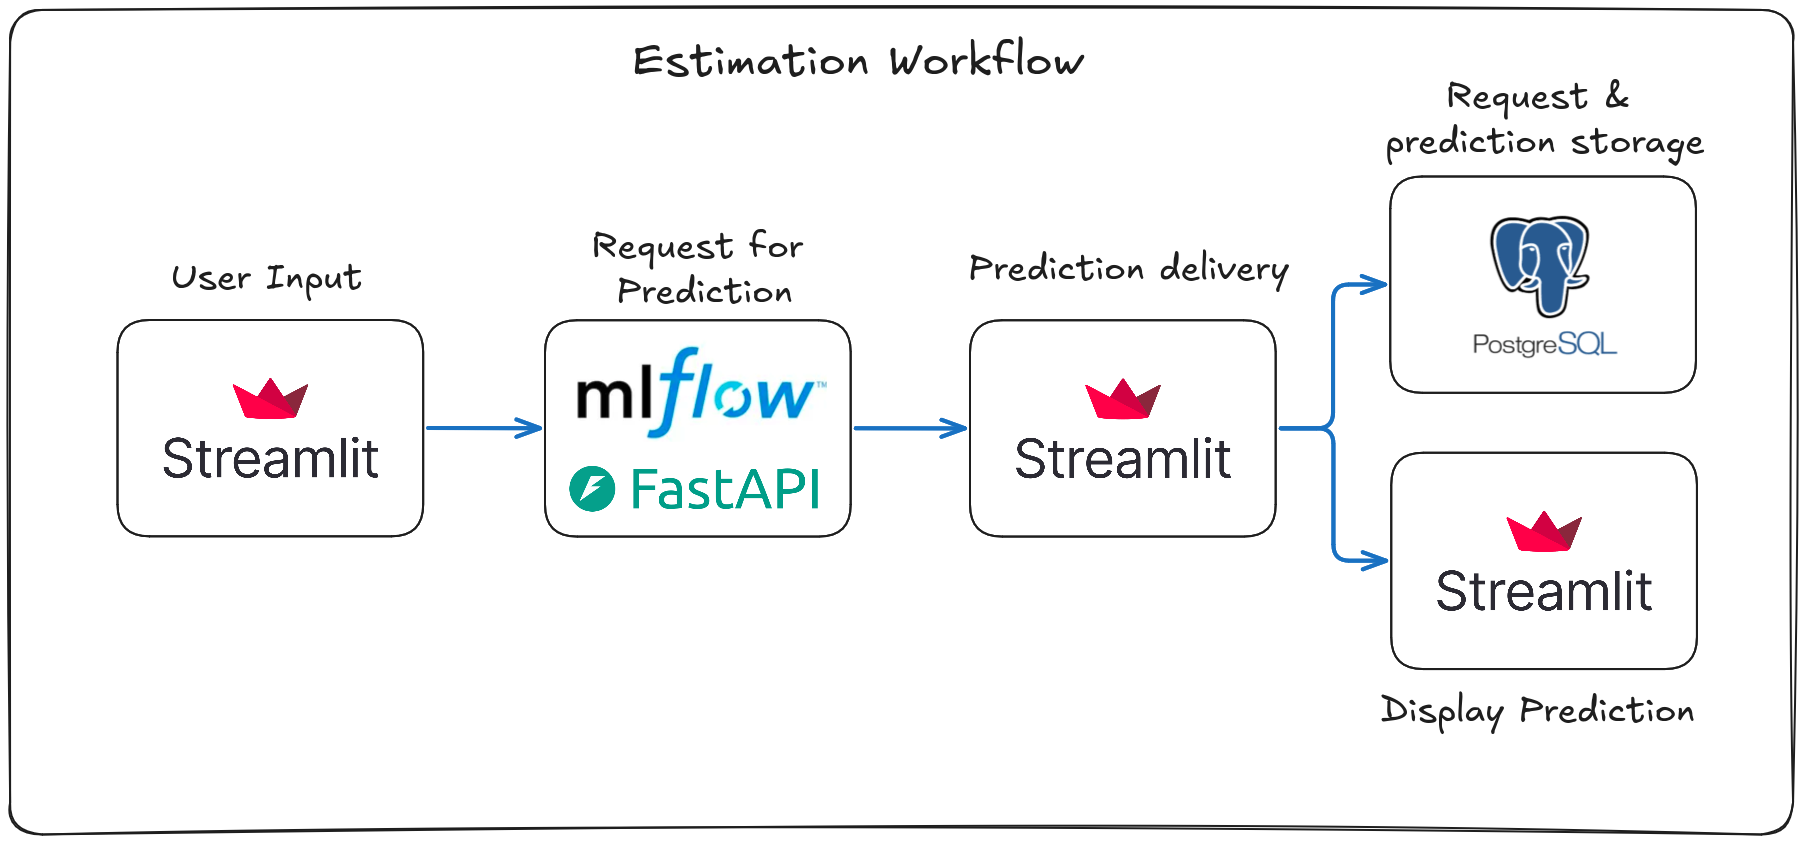

* **Prediction Workflow**:

  Runs whenever a user requests a price estimation in the **Streamlit app**.
  The user enters property details, which are sent to a **FastAPI service**.
  FastAPI queries the deployed model in **MLflow** to generate the prediction.
  The **predicted price** is immediately shown back to the user in **Streamlit**.
  Both the property details and the prediction result are then saved into the **PostgreSQL database** for tracking and future analysis.



## Airflow DAGs

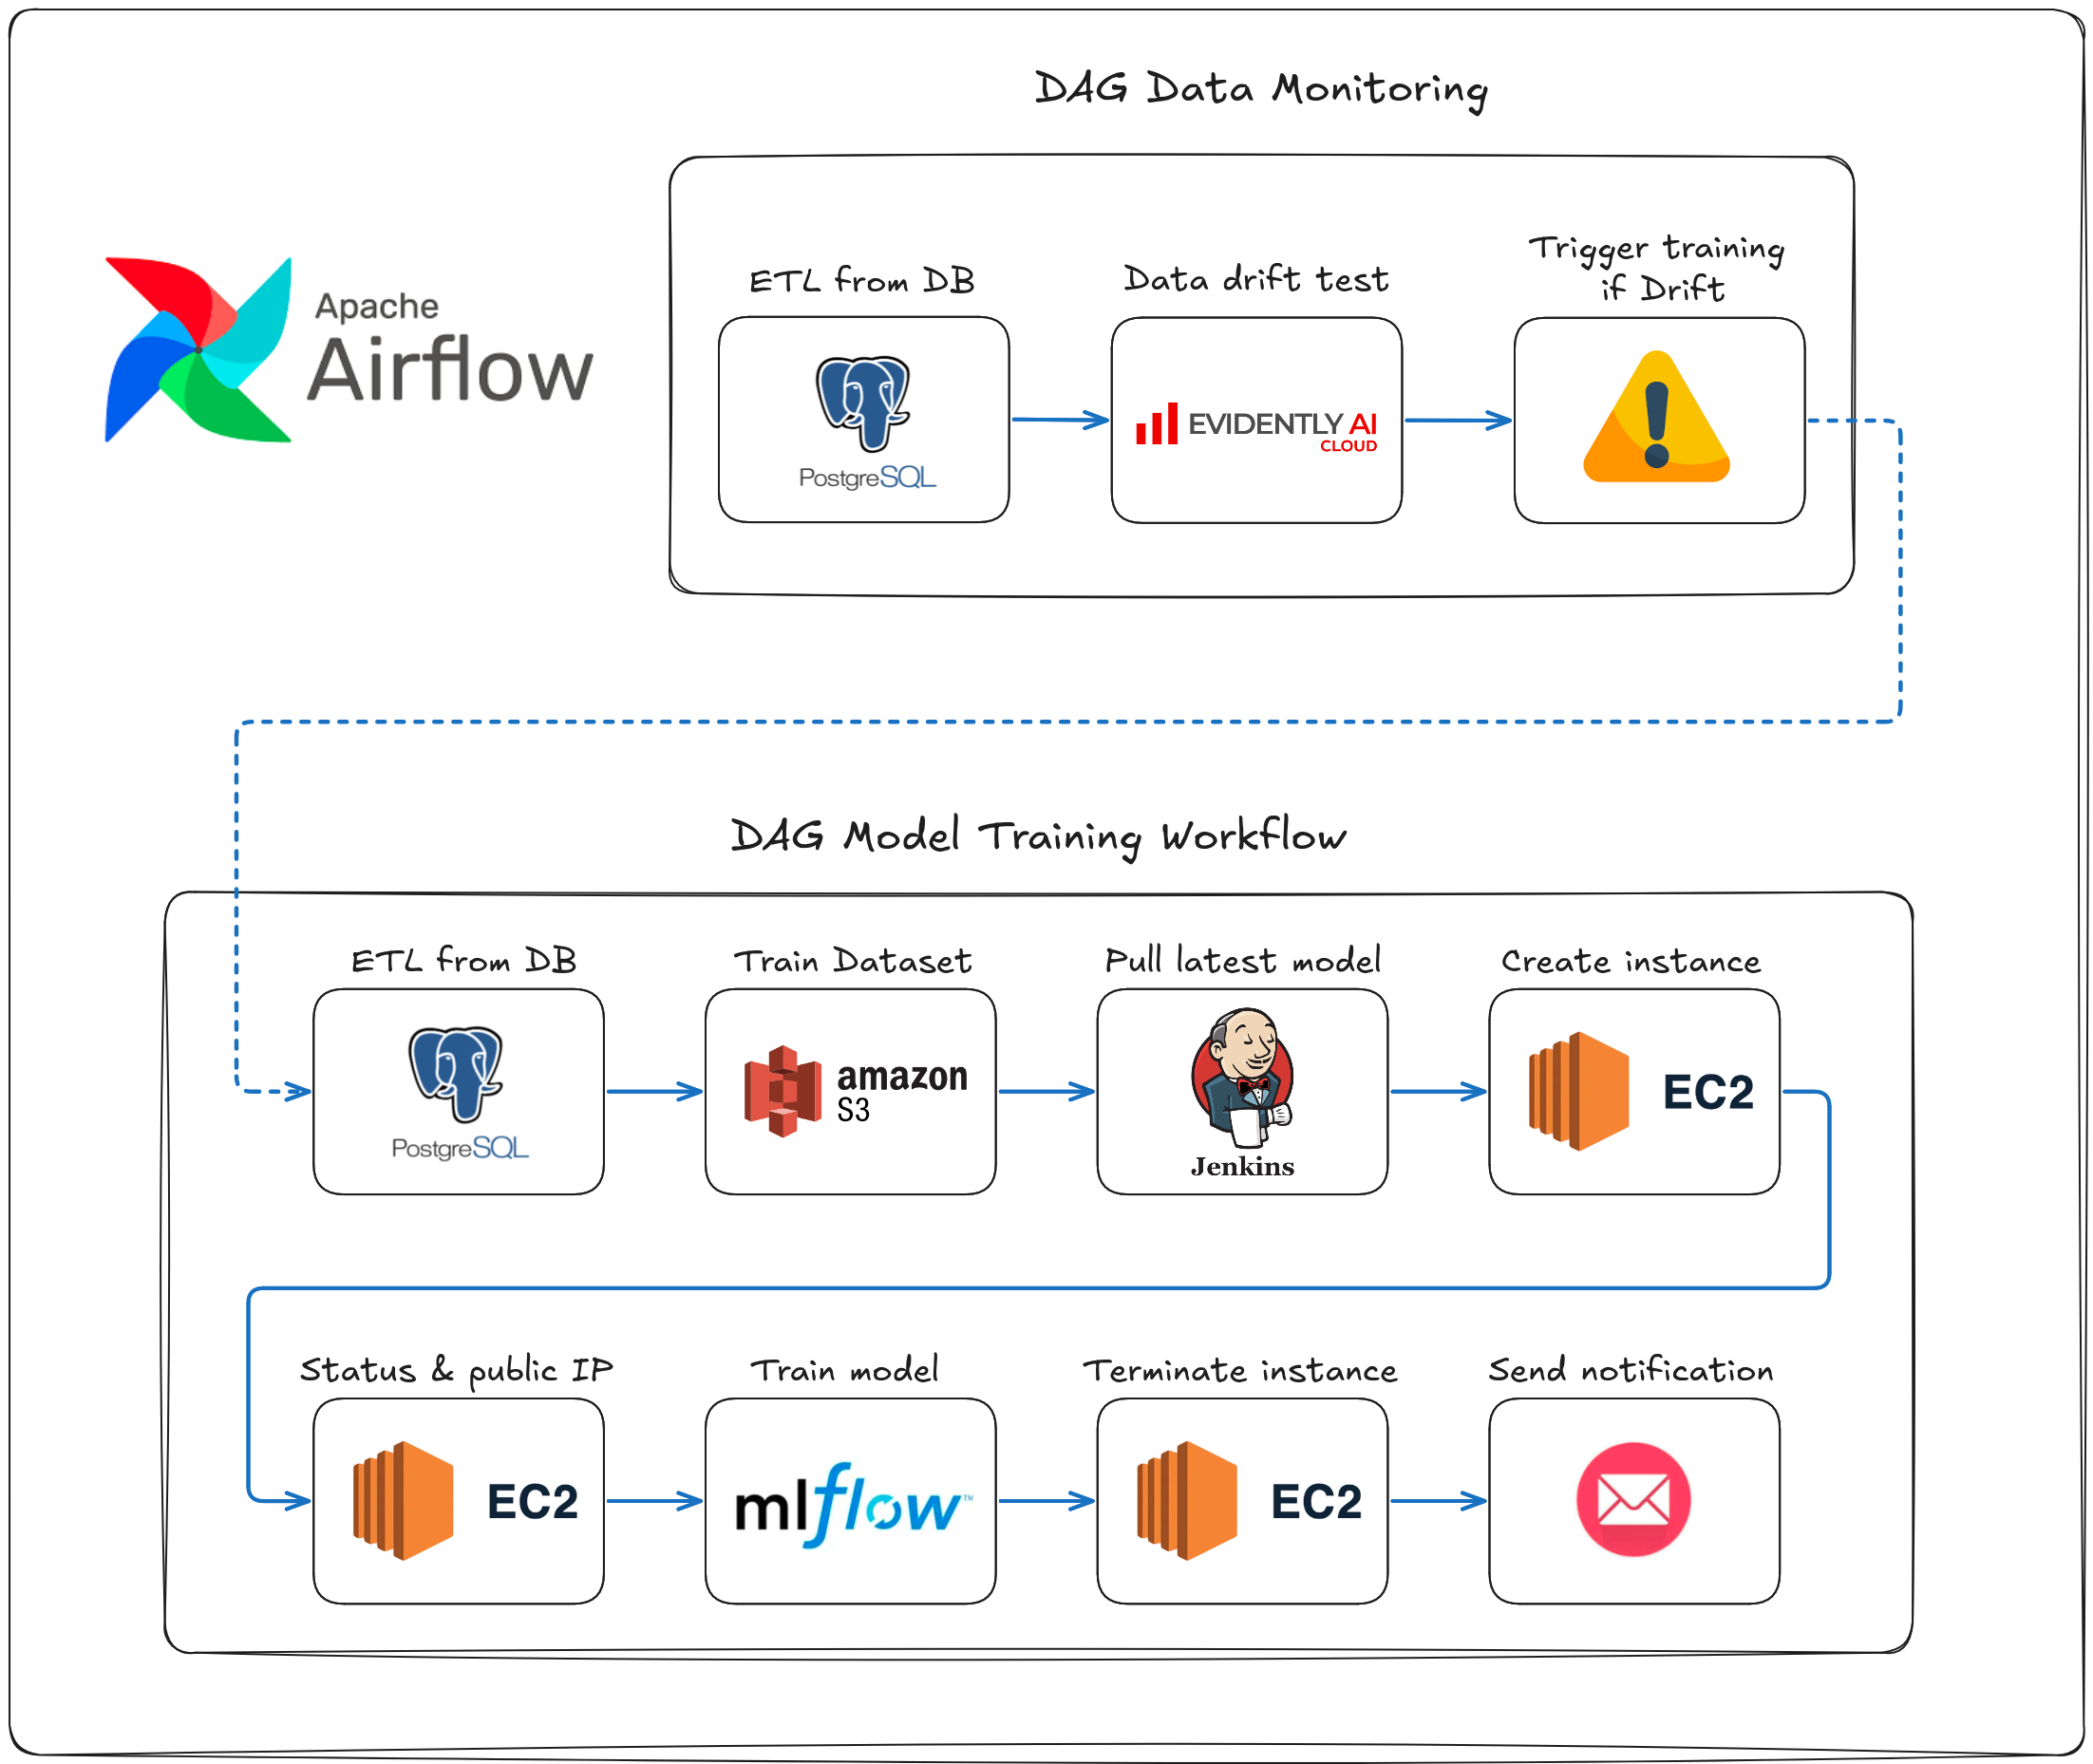

* **Data Drift Monitoring**:

  Runs on a schedule (e.g., daily).
  The pipeline extracts both recent and historical property data from the **PostgreSQL** database.
  Using **Evidently**, it monitors for **data drift** by checking feature distributions and target stability.

  * If **no drift is detected**, the workflow ends.
  * If **drift is detected**, the **Model Training Workflow** is triggered to update the prediction model.


* **Model Training Workflow**:

  A DAG triggered automatically when drift is detected (or manually if needed).
  It begins with an **ETL task** that extracts training data (only records with a real sale price) from the **PostgreSQL** database and stores a **snapshot in S3**.
  The model training process then uses this dataset from **S3** as input.
  Next, the workflow pulls the **latest validated model code** from **Jenkins**.
  An **EC2 instance** is launched to train a new **Linear Regression model**, with training fully managed and tracked in **MLflow**.
  Once training is complete, the **EC2 instance is automatically terminated** to optimize costs.


